# Analyzing the Firefox Engineering Workflow Data

In [3]:
import datetime
import json
from dateutil import parser
from pprint import pprint


def parse_record(record):
    # Parse a JSON workflow data record
    return dict(
        bug=record["bug"],
        bug_creation_ts=parser.parse(record["bug_creation_ts"]),
        rev=record["rev"],
        published_ts=parser.parse(record["published_ts"]),
        flow_time=datetime.timedelta(seconds=record["flow_time"])
    )


events = json.load(open("data/flowdata.json"), object_hook=parse_record)
pprint(events[0:5])

[{'bug': 1519107,
  'bug_creation_ts': datetime.datetime(2019, 1, 10, 14, 32, 35, tzinfo=tzutc()),
  'flow_time': datetime.timedelta(11, 78257),
  'published_ts': datetime.datetime(2019, 1, 22, 12, 16, 52, tzinfo=tzutc()),
  'rev': 'd532474e710f8a58ab10a2702dca432bc2eefa69'},
 {'bug': 1519107,
  'bug_creation_ts': datetime.datetime(2019, 1, 10, 14, 32, 35, tzinfo=tzutc()),
  'flow_time': datetime.timedelta(11, 78257),
  'published_ts': datetime.datetime(2019, 1, 22, 12, 16, 52, tzinfo=tzutc()),
  'rev': 'c367b5259d4683c8d7fcf7efdda68f6ca93f9913'},
 {'bug': 1519107,
  'bug_creation_ts': datetime.datetime(2019, 1, 10, 14, 32, 35, tzinfo=tzutc()),
  'flow_time': datetime.timedelta(11, 78257),
  'published_ts': datetime.datetime(2019, 1, 22, 12, 16, 52, tzinfo=tzutc()),
  'rev': '05ab29790c5718f31d2910f8728af5f742eaf14d'},
 {'bug': 1493184,
  'bug_creation_ts': datetime.datetime(2018, 9, 21, 14, 47, 25, tzinfo=tzutc()),
  'flow_time': datetime.timedelta(122, 77367),
  'published_ts': datet

In [54]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(events)
df.head()
seconds_duration = df["flow_time"].dt.total_seconds()
seconds_duration.head()
seconds_duration.max()

172689993.0

Dump any outliers

In [55]:
seconds_duration = seconds_duration.rolling(3).mean()
seconds_duration.dropna(inplace=True)
seconds_duration.max()

59397815.333333336

Text(0.5, 0, 'lead time (days)')

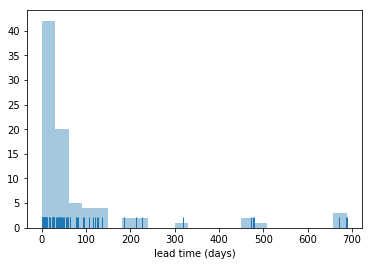

In [56]:
days_duration = seconds_duration.apply(lambda x: x / (3600 * 24))
g = sns.distplot(days_duration, kde=False, rug=True)
g.set_xlabel("lead time (days)")

In [57]:
days_duration.describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.95])

count     86.000000
mean      85.062216
std      149.713241
min        0.772728
25%        9.010214
50%       33.205554
75%       77.583051
90%      199.255559
95%      474.789171
max      687.474715
Name: flow_time, dtype: float64

Let's grab the landings within one standard deviation of the mean to see what a typical timeline looks like.

In [64]:
durations = days_duration.where(days_duration < (days_duration.mean() + days_duration.std()))
durations.dropna(inplace=True)
durations.describe()

count     79.000000
mean      44.619471
std       50.122547
min        0.772728
25%        8.436350
50%       27.736705
75%       55.762946
max      226.259171
Name: flow_time, dtype: float64

Text(0.5, 0, 'lead time (days)')

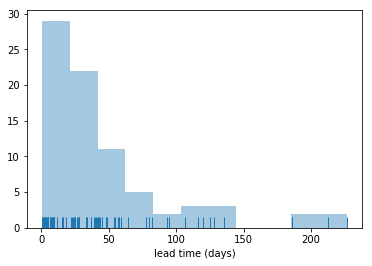

In [65]:
g = sns.distplot(durations, kde=False, rug=True)
g.set_xlabel("lead time (days)")